In [1]:
# Setup and Imports
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.envs.synthetic_env import BouncingBallEnv
from src.envs.atari_env import AtariPixelEnv
from src.models.vae import VAE
from src.models.transition import TransitionModel
from src.models.agent import ActiveInferenceAgent
from src.models.hierarchical_agent import HierarchicalAgent
from src.models.mlp_vae import MlpVAE
from src.trainer import ActiveInferenceTrainer

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


objc[12971]: Class CaptureDelegate is implemented in both /Users/yezune/ws/from_pixels_to_planning/.venv/lib/python3.14/site-packages/cv2/cv2.abi3.so (0x119ef25d8) and /opt/homebrew/Cellar/opencv/4.12.0_15/lib/libopencv_videoio.4.12.0.dylib (0x122120618). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[12971]: Class CVWindow is implemented in both /Users/yezune/ws/from_pixels_to_planning/.venv/lib/python3.14/site-packages/cv2/cv2.abi3.so (0x119ef2628) and /opt/homebrew/Cellar/opencv/4.12.0_15/lib/libopencv_highgui.4.12.0.dylib (0x121a28a70). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[12971]: Class CVView is implemented in both /Users/yezune/ws/from_pixels_to_planning/.venv/lib/python3.14/site-packages/cv2/cv2.abi3.so (0x119ef2650) and /opt/homebrew/Cellar/opencv/4.12.0_15/lib/libopencv_highgui.4.12.0.dylib (0x121a28a98). This may cause spu

## 1. Bouncing Ball Experiment (Phase 4)

We train a Flat Active Inference Agent on the Bouncing Ball environment and visualize the VAE reconstruction.

Training VAE...


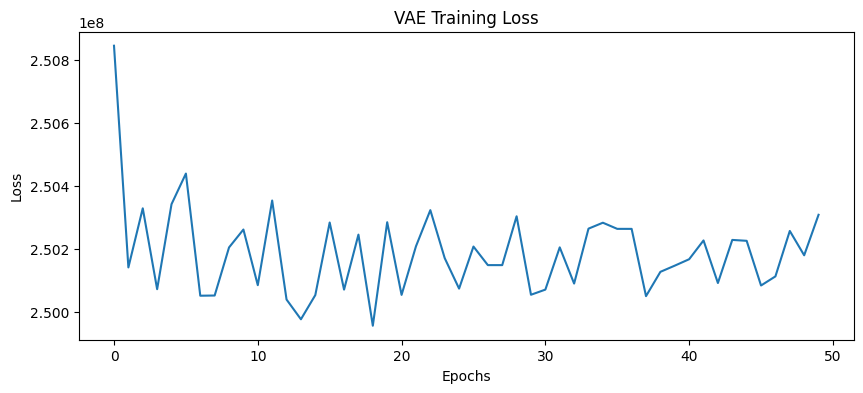

In [2]:
# Initialize Environment and Agent
env = BouncingBallEnv(size=32)
obs_shape = (3, 32, 32)
action_dim = env.action_space.n

vae = VAE(input_shape=obs_shape, latent_dim=16).to(device)
trans = TransitionModel(latent_dim=16, action_dim=action_dim, hidden_dim=32).to(device)
agent = ActiveInferenceAgent(vae, trans, action_dim, device=device)

trainer = ActiveInferenceTrainer(
    env=env,
    agent=agent,
    buffer_size=1000,
    batch_size=16,
    lr=1e-3,
    device=device
)

# Collect Data and Train (Short Run)
print("Collecting data...")
trainer.collect_data(num_steps=200)

print("Training VAE...")
vae_losses = []
for _ in range(50):
    loss = trainer.train_vae(epochs=1)
    vae_losses.append(loss)

plt.figure(figsize=(10, 4))
plt.plot(vae_losses)
plt.title("VAE Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

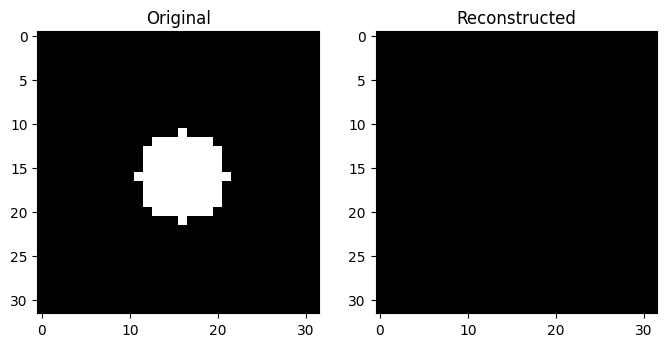

In [3]:
# Visualize Reconstruction
def visualize_reconstruction(agent, env):
    obs, _ = env.reset()
    
    # Prepare input
    if not isinstance(obs, torch.Tensor):
        obs_tensor = torch.tensor(obs, dtype=torch.float32, device=device)
    else:
        obs_tensor = obs.to(device)
        
    # Permute if needed (H, W, C) -> (C, H, W)
    if obs_tensor.shape[-1] == 3:
        obs_tensor = obs_tensor.permute(2, 0, 1)
    
    obs_tensor = obs_tensor.unsqueeze(0) # Add batch dim
    
    with torch.no_grad():
        recon, _, _ = agent.vae(obs_tensor)
        
    # Convert back to numpy for plotting
    orig_img = obs_tensor.squeeze().permute(1, 2, 0).cpu().numpy().astype(np.uint8)
    recon_img = recon.squeeze().permute(1, 2, 0).cpu().numpy()
    recon_img = np.clip(recon_img, 0, 255).astype(np.uint8)
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(orig_img)
    axes[0].set_title("Original")
    axes[1].imshow(recon_img)
    axes[1].set_title("Reconstructed")
    plt.show()

visualize_reconstruction(agent, env)

## 2. Atari Breakout Experiment (Phase 5)

We visualize the environment and the Hierarchical Agent's setup.

Atari Environment Loaded Successfully


A.L.E: Arcade Learning Environment (version 0.11.2+unknown)
[Powered by Stella]


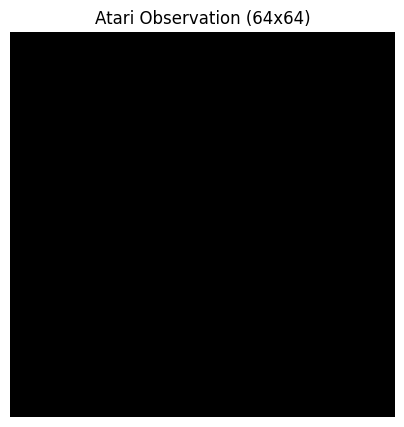

In [4]:
try:
    env_atari = AtariPixelEnv("BreakoutNoFrameskip-v4", image_size=64)
    print("Atari Environment Loaded Successfully")
    
    obs, _ = env_atari.reset()
    
    # Visualize Observation
    plt.figure(figsize=(5, 5))
    # Obs is (3, 64, 64) tensor
    plt.imshow(obs.permute(1, 2, 0).numpy().astype(np.uint8))
    plt.title("Atari Observation (64x64)")
    plt.axis('off')
    plt.show()
    
except Exception as e:
    print(f"Could not load Atari Environment: {e}")

## 3. Performance Comparison

Comparing Flat vs Hierarchical Agents based on `comparison_results.json`.

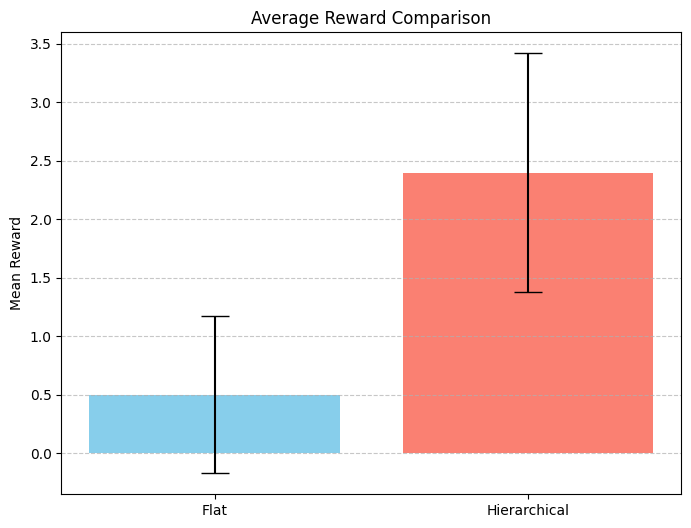

Detailed Results:
{
    "Flat": {
        "rewards": [
            0.0,
            0.0,
            0.0,
            1.0,
            0.0,
            0.0,
            1.0,
            2.0,
            0.0,
            1.0
        ],
        "lengths": [
            496.0,
            498.0,
            494.0,
            603.0,
            496.0,
            499.0,
            611.0,
            731.0,
            498.0,
            614.0
        ],
        "mean_reward": 0.5,
        "std_reward": 0.6708203932499369,
        "mean_length": 554.0
    },
    "Hierarchical": {
        "rewards": [
            4.0,
            3.0,
            2.0,
            2.0,
            2.0,
            3.0,
            3.0,
            3.0,
            0.0,
            2.0
        ],
        "lengths": [
            1000.0,
            1000.0,
            790.0,
            792.0,
            787.0,
            989.0,
            991.0,
            984.0,
            489.0,
            787.0
   

In [5]:
results_path = os.path.join(project_root, 'comparison_results.json')

if os.path.exists(results_path):
    with open(results_path, 'r') as f:
        results = json.load(f)
        
    names = list(results.keys())
    means = [results[n]['mean_reward'] for n in names]
    stds = [results[n]['std_reward'] for n in names]
    
    plt.figure(figsize=(8, 6))
    plt.bar(names, means, yerr=stds, capsize=10, color=['skyblue', 'salmon'])
    plt.title("Average Reward Comparison")
    plt.ylabel("Mean Reward")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    print("Detailed Results:")
    print(json.dumps(results, indent=4))
else:
    print("comparison_results.json not found. Run 'src/experiments/run_comparison.py' first.")

## 4. MNIST Classification (Spatial Renormalization)

이 섹션에서는 정적 이미지(MNIST)에 대한 공간적 재규격화(Spatial Renormalization) 모델을 실험합니다.
간단한 Spatial RGM 모델을 학습시키고, 다음을 시각화합니다:
1.  **Reconstruction**: 원본 이미지와 모델이 복원한 이미지 비교.
2.  **Generation**: 잠재 공간(Latent Space)에서 샘플링하여 생성된 숫자 이미지.

In [6]:
from src.experiments.mnist_experiment import MNISTExperiment
import torch
import matplotlib.pyplot as plt
import numpy as np

# 장치 설정 (이전 셀에서 설정되었을 수 있지만 안전을 위해 다시 확인)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# MNIST 실험 실행 (빠른 확인을 위해 에포크를 3으로 설정)
print("Training Spatial RGM on MNIST...")
mnist_exp = MNISTExperiment(batch_size=64, epochs=3, device=device)
mnist_exp.run()

Using device: cpu
Training Spatial RGM on MNIST...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:01<00:00, 5.18MB/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 143kB/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:01<00:00, 1.57MB/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 8.60MB/s]


Starting training on cpu...
Epoch [1/3], Step [0/938], Loss: 183.0590
Epoch [1/3], Step [100/938], Loss: 75.4553
Epoch [1/3], Step [200/938], Loss: 56.6955
Epoch [1/3], Step [300/938], Loss: 52.9392
Epoch [1/3], Step [400/938], Loss: 45.4691
Epoch [1/3], Step [500/938], Loss: 45.8268
Epoch [1/3], Step [600/938], Loss: 43.3460
Epoch [1/3], Step [700/938], Loss: 42.8531
Epoch [1/3], Step [800/938], Loss: 41.6694
Epoch [1/3], Step [900/938], Loss: 38.1625
Epoch [1/3] Finished. Avg Loss: 53.2872, Test Accuracy: 91.66%
Epoch [2/3], Step [0/938], Loss: 39.3381
Epoch [2/3], Step [100/938], Loss: 38.2808
Epoch [2/3], Step [200/938], Loss: 39.1818
Epoch [2/3], Step [300/938], Loss: 35.7568
Epoch [2/3], Step [400/938], Loss: 37.2347
Epoch [2/3], Step [500/938], Loss: 39.3132
Epoch [2/3], Step [600/938], Loss: 37.5981
Epoch [2/3], Step [700/938], Loss: 34.7640
Epoch [2/3], Step [800/938], Loss: 32.7857
Epoch [2/3], Step [900/938], Loss: 34.0981
Epoch [2/3] Finished. Avg Loss: 36.7546, Test Accura

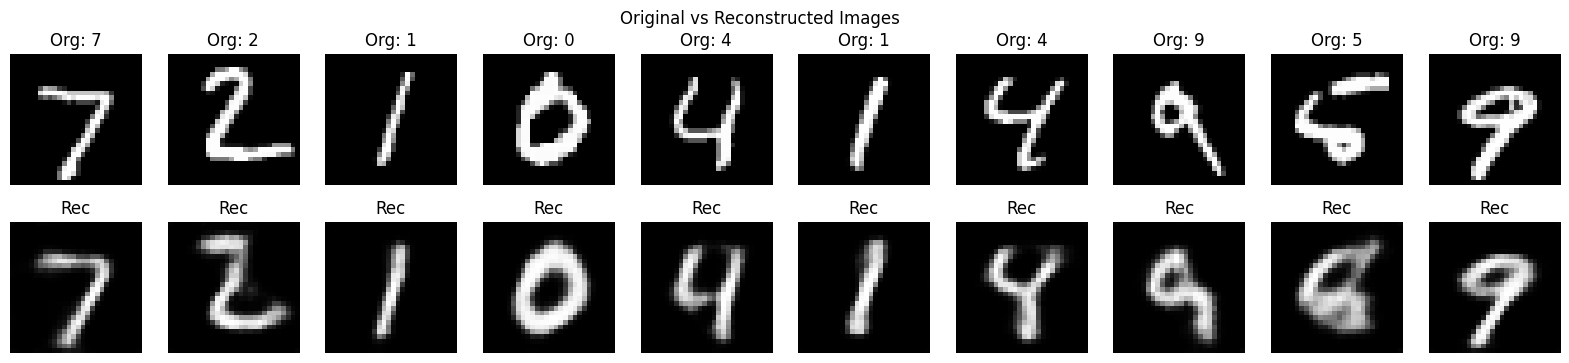

In [7]:
# 1. Reconstruction Visualization
model = mnist_exp.model
model.eval()
test_loader = mnist_exp.get_loaders()[1]

# 테스트 데이터 배치 하나 가져오기
data_iter = iter(test_loader)
images, labels = next(data_iter)
images = images.to(device)

# 모델 추론
with torch.no_grad():
    recon, logits, _ = model(images)

# 시각화
n = 10  # 보여줄 이미지 개수
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i].cpu().squeeze(), cmap='gray')
    plt.title(f"Org: {labels[i].item()}")
    plt.axis('off')

    # Reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon[i].cpu().squeeze(), cmap='gray')
    plt.title(f"Rec")
    plt.axis('off')
plt.suptitle("Original vs Reconstructed Images")
plt.show()

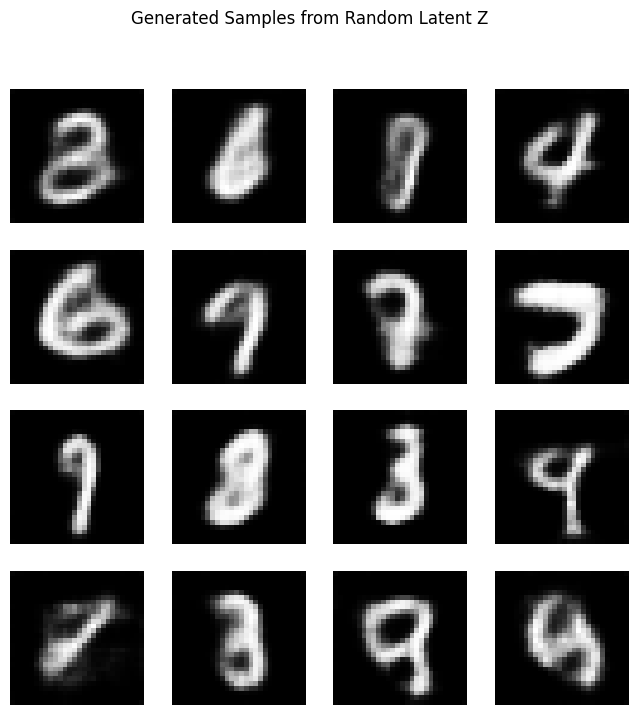

In [8]:
# 2. Generation Visualization (Sampling from Latent Space)
# 잠재 공간(Latent Space)에서 무작위로 샘플링하여 이미지를 생성합니다.
# 이는 모델이 학습한 데이터 분포를 얼마나 잘 캡처했는지 보여줍니다.

with torch.no_grad():
    # 표준 정규 분포에서 z 샘플링
    z = torch.randn(16, model.latent_dim).to(device)
    
    # Decoder를 통해 이미지 생성
    d_in = model.decoder_input(z)
    d_in = d_in.view(-1, 64, 7, 7)
    generated_imgs = model.decoder(d_in)

# 생성된 이미지 시각화
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_imgs[i].cpu().squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Generated Samples from Random Latent Z")
plt.show()